In [2]:
from training_rl.offline_rl.custom_envs.custom_envs_registration import register_grid_envs
import warnings
from training_rl.offline_rl.load_env_variables import load_env_variables
import gymnasium as gym
from training_rl.offline_rl.utils import one_hot_to_integer
from training_rl.offline_rl.custom_envs.custom_2d_grid_env.simple_grid import Custom2DGridEnv
import numpy as np
from training_rl.offline_rl.scripts.visualizations.utils import snapshot_env
from training_rl.offline_rl.custom_envs.custom_2d_grid_env.obstacles_2D_grid_register import ObstacleTypes
from training_rl.offline_rl.custom_envs.utils import Grid2DInitialConfig, InitialConfigCustom2DGridEnvWrapper
from training_rl.offline_rl.custom_envs.custom_envs_registration import CustomEnv, RenderMode
from training_rl.offline_rl.offline_policies.offpolicy_rendering import offpolicy_rendering
from random import random
import minari
from minari import StepDataCallback, DataCollectorV0
from training_rl.offline_rl.utils import delete_minari_data_if_exists
from training_rl.offline_rl.generate_custom_minari_datasets.utils import generate_compatible_minari_dataset_name
from training_rl.offline_rl.scripts.visualizations.utils import get_state_action_data_and_policy_grid_distributions
from training_rl.offline_rl.utils import load_buffer_minari, state_action_histogram


load_env_variables()

warnings.filterwarnings("ignore")
# To get access to the registered environments.
register_grid_envs()

**In this notebook, we will create our own suboptimal policy and generate a Minari dataset using the collected data. The primary goal is to become familiar with the Minari library and learn how to collect data in the form of (step, action, reward) using it.**

**We will design a suboptimal behavioral policy, denoted as $\pi_b$, to guide an agent through a 2-dimensional 8x8 grid world. The agent's starting position is at (0, 0), and the objective is to reach a target located at (0, 7). During this process, we will collect data from our policy.**

**Notation:**

In our grid world environment, the agent's position is represented as $(x_1, x_2)$, where $x_1$ corresponds to the vertical coordinate, and $x_2 corresponds to the horizontal coordinate. Additionally, we've placed obstacles within the environment to increase the task's complexity.

Observations are represented as a 64-dimensional vector since we are working with an 8x8 grid. All vector elements are set to zero, except for the position where the agent is located, which is set to one.

The action is represented by an integer in the range of [0, 1, 2, 3], each indicating a direction:

    0: (-1, 0) - UP
    1: (1, 0) - DOWN
    2: (0, -1) - LEFT
    3: (0, 1) - RIGHT

Now, let's proceed to create the environment and take a closer look at it.

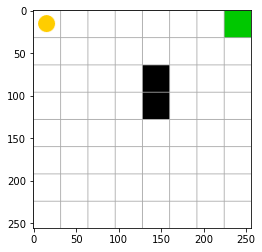

In [3]:
# We have different 2-d grid environments registered.
ENV_NAME = CustomEnv.Grid_2D_8x8_discrete
RENDER_MODE = RenderMode.RGB_ARRAY_LIST


# Configure the environment initial conditions. We also have different obstacles regidterd
# in ObstacleTypes. 
env_2d_grid_initial_config = Grid2DInitialConfig(
    obstacles=ObstacleTypes.verical_object_8x8,
    initial_state=(0, 0),
    target_state=(0, 7),
)

env = InitialConfigCustom2DGridEnvWrapper(
    gym.make(ENV_NAME, render_mode=RENDER_MODE),
    env_config=env_2d_grid_initial_config
)

snapshot_env(env)

### Exercise 1:

Create a suboptimal behavioral policy, $\pi_b$:

    def behavior_suboptimal_policy(state: np.ndarray, env: 
                                                     Custom2DGridEnv) -> int:

        state_index = one_hot_to_integer(state)
        state_xy = env.to_xy(state_index)

        ...

        return action
        
(Note: In practical scenarios, the environment would not be supplied to the policy. We include it here for simplicity.)

This policy should meet the following criteria:

1 - Guide the agent from its initial position at (0, 0) to a target located at (0, 7).

2 - Incorporate stochastic movement with a restriction of not traversing more than 5 cells 
    vertically while introducing a bias towards the right direction to make it suboptimal.
    
Hint: To ensure that everything is working correctly, you can visualize the policy using the **behavior_policy_rendering(...)** function:

    behavior_policy_rendering(
        env_or_env_name=ENV_NAME,
        render_mode=RENDER_MODE,
        behavior_policy= behavior_suboptimal_policy,
        env_2d_grid_initial_config=env_2d_grid_initial_config,
        num_frames=1000,
    )

**SOLUTION:**

In [4]:
def behavior_suboptimal_policy(state: np.ndarray, env: Custom2DGridEnv) -> int:

    state_index = one_hot_to_integer(state)
    state_xy = env.to_xy(state_index)

    possible_directions = [0, 1, 2, 3]
    weights = [1, 1, 1, 2]

    if state_xy[0] == 4:
        weights = [2, 1, 2]
        possible_directions = [0, 2, 3]

    random_directions = random.choices(possible_directions, weights=weights)[0]

    return random_directions

offpolicy_rendering(
    env_or_env_name=ENV_NAME,
    render_mode=RENDER_MODE,
    policy_model= behavior_suboptimal_policy,
    env_2d_grid_initial_config=env_2d_grid_initial_config,
    num_frames=1000,
)

QObject::moveToThread: Current thread (0x55631227c3a0) is not the object's thread (0x556312284cc0).
Cannot move to target thread (0x55631227c3a0)

QObject::moveToThread: Current thread (0x55631227c3a0) is not the object's thread (0x556312284cc0).
Cannot move to target thread (0x55631227c3a0)

QObject::moveToThread: Current thread (0x55631227c3a0) is not the object's thread (0x556312284cc0).
Cannot move to target thread (0x55631227c3a0)

QObject::moveToThread: Current thread (0x55631227c3a0) is not the object's thread (0x556312284cc0).
Cannot move to target thread (0x55631227c3a0)

QObject::moveToThread: Current thread (0x55631227c3a0) is not the object's thread (0x556312284cc0).
Cannot move to target thread (0x55631227c3a0)

QObject::moveToThread: Current thread (0x55631227c3a0) is not the object's thread (0x556312284cc0).
Cannot move to target thread (0x55631227c3a0)

QObject::moveToThread: Current thread (0x55631227c3a0) is not the object's thread (0x556312284cc0).
Cannot move to tar

InterruptedError: You quit ('q') the animation.

Now, using our suboptimal policy, we will proceed to collect data and generate a custom Minari dataset.

But first, let's give a look to the [Minari documentation](https://minari.farama.org/main/content/basic_usage/).

**EXERCISE 2:**

Create your own Minari dataset using the behavior_suboptimal_policy.

Hint: Remember to use the DataCollectorV0 wrapper provided in the Minari library.

SOLUTION:

In [9]:
DATA_SET_NAME = "data"
DATA_SET_IDENTIFIER = "_rl_workshop"
VERSION_DATA_SET = "v0"
BUFFER_SIZE = 1000


DATA_SET_NAME += DATA_SET_IDENTIFIER
minari_dataset_name = generate_compatible_minari_dataset_name(ENV_NAME, DATA_SET_NAME, VERSION_DATA_SET)

delete_minari_data_if_exists(minari_dataset_name)

# Usefull for data preprocessing
class CustomSubsetStepDataCallback(StepDataCallback):
    def __call__(self, env, **kwargs):
        step_data = super().__call__(env, **kwargs)
        #del step_data["observations"]["achieved_goal"]
        return step_data

env = DataCollectorV0(
    env,
    step_data_callback=CustomSubsetStepDataCallback,
    record_infos=False,
)

state, _ = env.reset()

num_steps = 0
for _ in range(BUFFER_SIZE):

    action = behavior_suboptimal_policy(state, env)

    next_state, reward, done, time_out, info = env.step(action)
    num_steps += 1

    if done or time_out:
        state, _ = env.reset()
        num_steps=0
    else:
        state = next_state


dataset = minari.create_dataset_from_collector_env(dataset_id=minari_dataset_name, collector_env=env)

Dataset Grid_2D_8x8_discrete-data_rl_workshop-v0 deleted!


Let's visualize the state-action distribution data.

First, let's upload the Minari dataset in a Tainshou ReplyBuffer object.

Dataset /home/ivan/Documents/GIT_PROJECTS/Tianshou/tianshou/examples/offline_RL_workshop/data/offline_data/Grid_2D_8x8_discrete-data_rl_workshop-v0 downloaded. number of episodes: 22


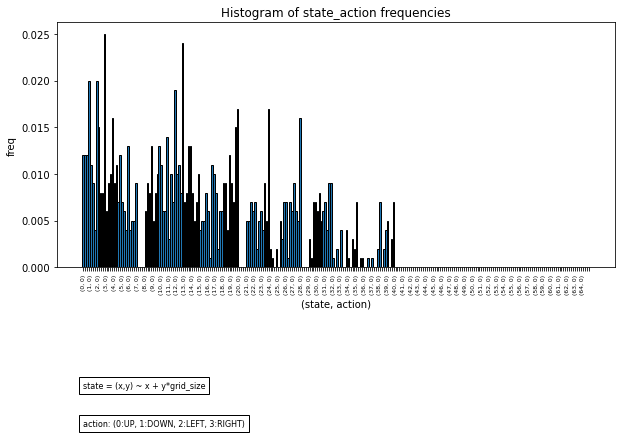

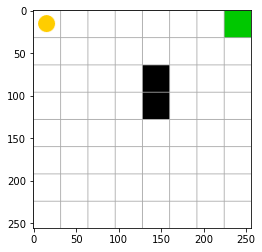

In [12]:
NAME_EXPERT_DATA = "Grid_2D_8x8_discrete-data_rl_workshop-v0"
data = load_buffer_minari(NAME_EXPERT_DATA)

state_action_count_data, _ = \
    get_state_action_data_and_policy_grid_distributions(data, env)

state_action_histogram(state_action_count_data, title="State-Action data distribution")
snapshot_env(env)

The distribution makes sense. From states 40 to 64 (i.e., (5,0) to (7,7)), our policy doesn't collect any data, neither around the obstacle.

### References

[ \[Fu.Justin et. al.\] D4RL: Datasets for Deep Data-Driven Reinforcement Learning](https://arxiv.org/abs/2004.07219)

[ MINARI: A dataset API for Offline Reinforcement Learning ](https://minari.farama.org/main/content/basic_usage/) 